In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense,Dropout,SimpleRNN
from keras.models import Sequential

#from prophet.plot import add_changepoints_to_plot

from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

Data
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the PJM East which has data from 2002-2018 for the entire east region.

In [2]:
pjme = pd.read_csv('input/PJME_hourly.csv',
                   index_col=[0], parse_dates=[0]) # We set the index column and know it has dates
pjme

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


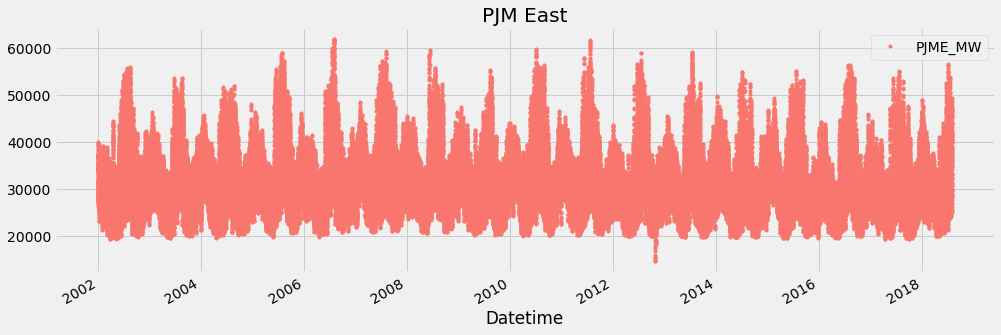

In [3]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')
plt.show()

EDA
We will creat some time series features to see how the trends are impacted by day of week, hour, time of year, etc.

In [4]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    #df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

In [5]:
# See our features and target
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-01-01 01:00:00,1,1,1,1,2002,1,1,1,30393.0
2002-01-01 02:00:00,2,1,1,1,2002,1,1,1,29265.0
2002-01-01 03:00:00,3,1,1,1,2002,1,1,1,28357.0
2002-01-01 04:00:00,4,1,1,1,2002,1,1,1,27899.0
2002-01-01 05:00:00,5,1,1,1,2002,1,1,1,28057.0


Plotting the Features to see trends
Power demand has strong daily and seasonal properties.
Day of week also seems to show differences in peaks

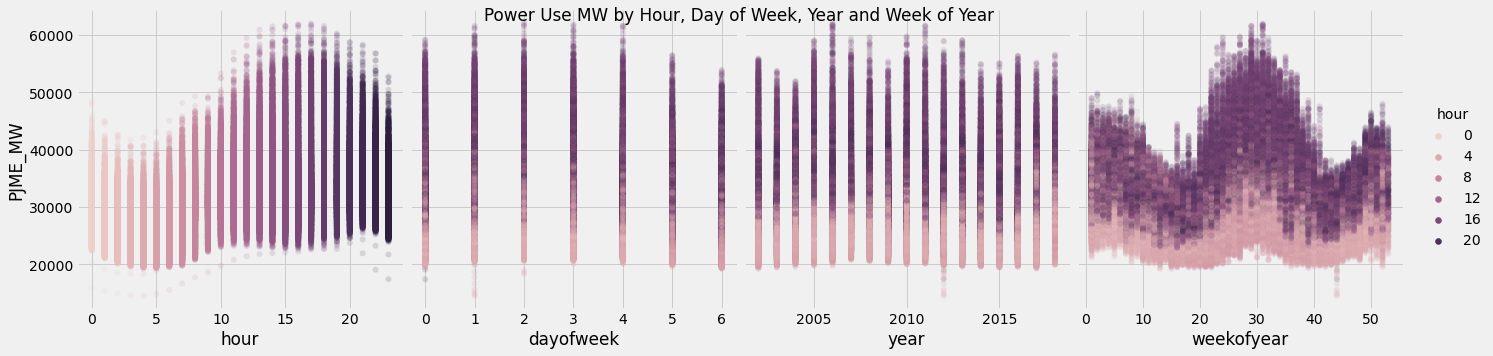

In [6]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

Train/Test Split
Cut off the data after 2015 to use as our validation set. We will train on earlier data.

In [7]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

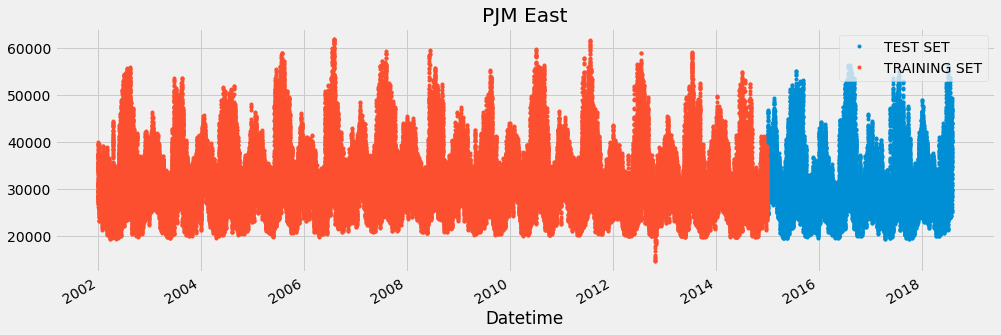

In [8]:
# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

Simple Prophet Model
Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.

In [9]:
# Format data for prophet model using ds and y
pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'}).head()

,ds,y
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0


In [10]:
import time
t0= time.time()

# Setup and train model and fit
model = Prophet(changepoint_prior_scale=0.05)
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW':'y'}))

print("training time elapsed: %s seconds" % (time.time() - t0))

training time elapsed: 598.951319694519 seconds


In [11]:
# Predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [12]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31209.322697,23889.610114,32813.996857,31209.322697,31209.322697,-2823.261647,-2823.261647,-2823.261647,-4430.381997,...,1281.422392,1281.422392,1281.422392,325.697958,325.697958,325.697958,0.0,0.0,0.0,28386.061050
1,2015-01-01 02:00:00,31209.284876,22110.643952,31338.694324,31209.284876,31209.284876,-4327.708248,-4327.708248,-4327.708248,-5927.391284,...,1272.663684,1272.663684,1272.663684,327.019351,327.019351,327.019351,0.0,0.0,0.0,26881.576628
2,2015-01-01 03:00:00,31209.247055,22015.285901,30679.412033,31209.247055,31209.247055,-5199.396321,-5199.396321,-5199.396321,-6790.477791,...,1262.699251,1262.699251,1262.699251,328.382219,328.382219,328.382219,0.0,0.0,0.0,26009.850734
3,2015-01-01 04:00:00,31209.209234,21463.805580,29935.480880,31209.209234,31209.209234,-5340.838206,-5340.838206,-5340.838206,-6922.277506,...,1251.652713,1251.652713,1251.652713,329.786587,329.786587,329.786587,0.0,0.0,0.0,25868.371028
4,2015-01-01 05:00:00,31209.171413,22113.503530,31167.068475,31209.171413,31209.171413,-4666.351087,-4666.351087,-4666.351087,-6237.243470,...,1239.659902,1239.659902,1239.659902,331.232480,331.232480,331.232480,0.0,0.0,0.0,26542.820326


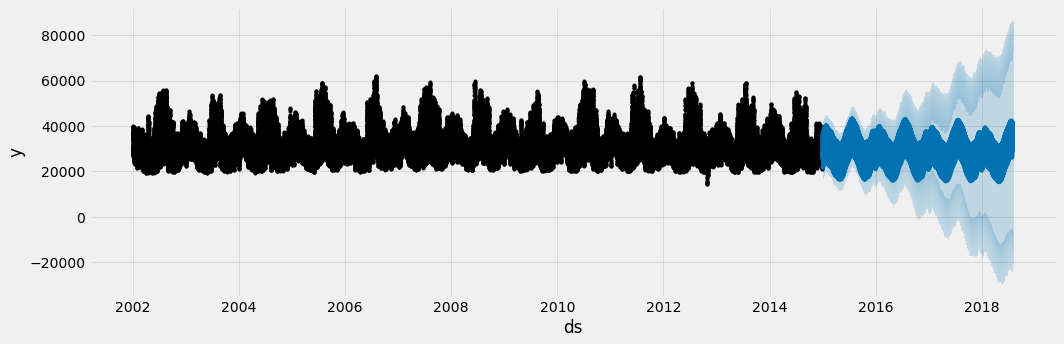

In [13]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

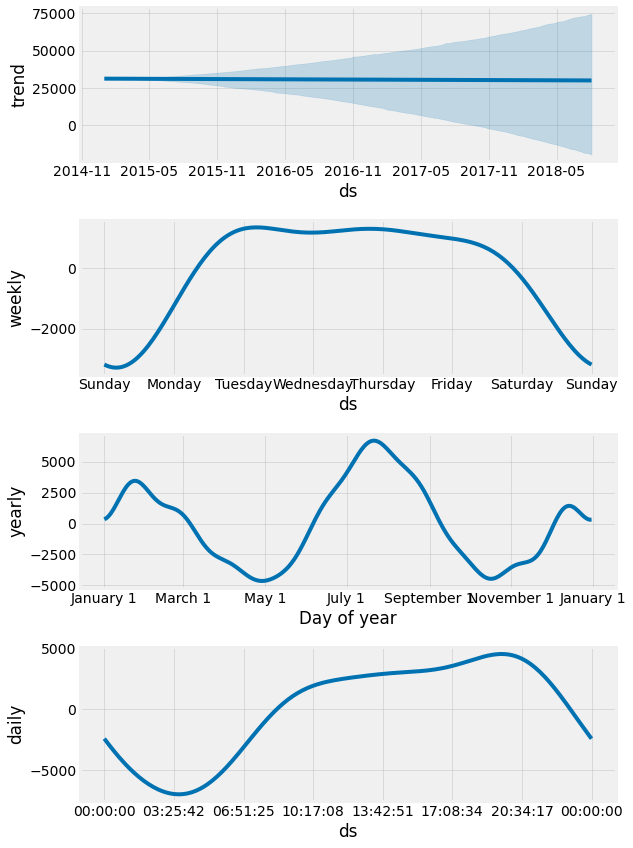

In [14]:
# Plot the components of the model
fig = model.plot_components(pjme_test_fcst)

Compare Forecast to Actuals

(10000.0, 60000.0)

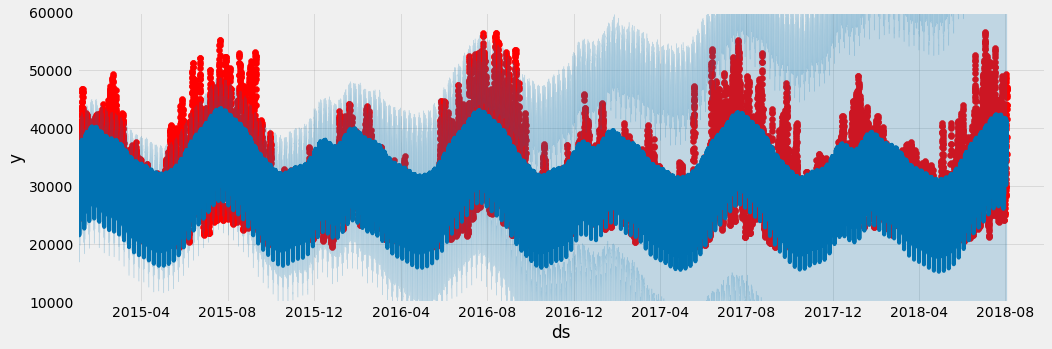

In [15]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
plt.xlim([16436,17800])
plt.ylim([10000,60000])

Look at first month of predictions

(16436, 16466)

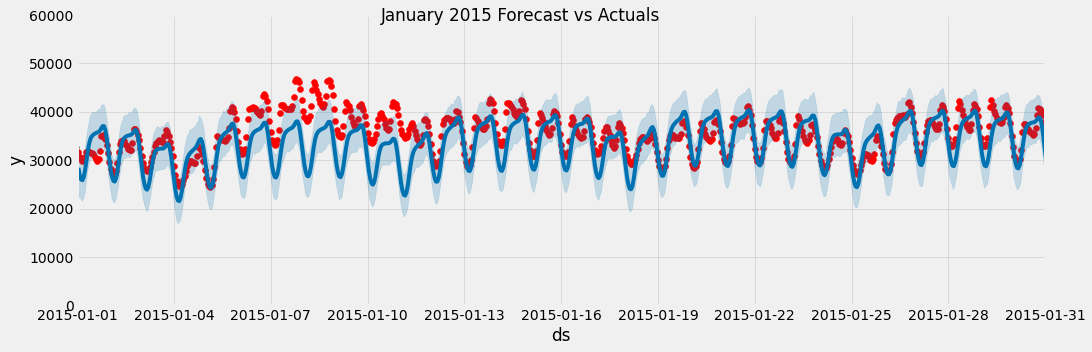

In [16]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
#ax.set_xbound(lower='01-01-2015',
#              upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')
plt.xlim([16436,16466])

Single Week of Predictions

(16436, 16443)

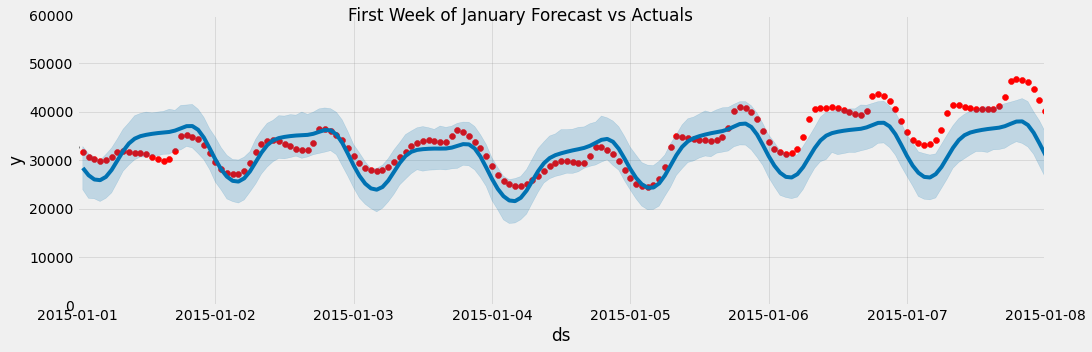

In [17]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
#ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')
plt.xlim([16436,16443])

Error Metrics
Our RMSE error is 43761675
Our MAE error is 5181.78
Our MAPE error is 16.5%

by comparison in the XGBoost model our errors were significantly less (8.9% MAPE): Check that out here

In [18]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

17005819.149178702

In [19]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

3104.9814373577765

In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

9.618187714844808

Adding Holidays
Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays

Predict With Holidays

Plot Holiday Effect

Error Metrics with Holidays Added
Suprisingly the error has gotten worse after adding holidays.

Compare Models Just for Holiday Dates
Lets plot Forecast model with and without holidays for 4th of July. It does look like the model with holidays is more accurate for this holiday.

Compare Error for just 4th of July
The error has gone down for this date.

Error of all Holidays
Holiday error has gone up! This is unexpected.

Identify Error by holiday
We can see different holidays respond differently in this model. The model would perform better if we specifically identify holidays instead of lumping them all together as "USFederalHolidays"

Plot Error of Each Forecast
We can see that both of our models generalize well, but struggle with peak demand days.
Seems to be under forecasting many days.

Data Cleaning
Data cleaning is a very important part of the forecasting process. If the input data contains garbage values, the forecast will use them when making predictions and could cause serious issues.
We notice in the training data that we have some bad measurements where the values are much less. Could these be causing the under forecasting? Lets try removing this bad data.
This plot shows the bad data highlighted in red.

What caused this dip in energy demand? Hurricane Sandy! Check out this wikipedia article: https://en.wikipedia.org/wiki/List_of_major_power_outages#2012

On October 29–30, Hurricane Sandy brought high winds and coastal flooding to a large portion of the eastern United States, leaving an estimated 8 million customers without power. The storm, which came ashore near Atlantic City, New Jersey as a Category 1 hurricane, ultimately left scores of homes and businesses without power in New Jersey (2.7 million), New York (2.2 million), Pennsylvania (1.2 million), Connecticut (620,000), Massachusetts (400,000), Maryland (290,000), West Virginia (268,000), Ohio (250,000), and New Hampshire (210,000). Power outages were also reported in a number of other states, including Virginia, Maine, Rhode Island, Vermont, and the District of Columbia.

After cleaning we see a slight improvement in score compared to the first model. More data cleaning, along with holidays could yield even better results. Give it a try!